In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

mnist_data_train = torchvision.datasets.MNIST('./data/mnist', download=True, transform=torchvision.transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, transform=torchvision.transforms.ToTensor())

mnist_trainloader = torch.utils.data.DataLoader(mnist_data_train, batch_size=16, shuffle=True)
mnist_testloader = torch.utils.data.DataLoader(mnist_data_test, batch_size=16, shuffle=True)

svhn_data_train = torchvision.datasets.SVHN('./data/svhn', download=True, transform=torchvision.transforms.ToTensor())
svhn_data_test = torchvision.datasets.SVHN('./data/svhn', split='test', download=True, transform=torchvision.transforms.ToTensor())

svhn_trainloader = torch.utils.data.DataLoader(svhn_data_train, batch_size=32, shuffle=True)
svhn_testloader = torch.utils.data.DataLoader(svhn_data_test, batch_size=32, shuffle=True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [8]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def kl_divergence(mu, log_sigma_sq):
  '''KL divergence between a Gaussian N(mu, sigma) and N(0, 1).'''
  return -0.5 * torch.mean(-mu**2 + log_sigma_sq - log_sigma_sq.exp() + 1)

def train(vae, trainloader, epochs=3, lr=0.001, debug_with_images=False, crit=None):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
  print('Using device ', device)

  vae = vae.to(device)

  if crit == None:
    criterion = torch.nn.MSELoss()#(reduction='sum')
  else:
    criterion = crit

  optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
  total_loss = []

  for epoch in range(epochs):
    print('Epoch ', epoch)
    losses = []
    for traindata, label in trainloader:
      traindata = traindata.to(device)
      label = label.to(device)
      result = vae(traindata).to(device)
      loss = criterion(result.reshape(traindata.shape), traindata) + kl_divergence(vae.mus, vae.sigmas)# rec_loss + kld      
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      losses.append(loss.detach())
    if debug_with_images:
      try:
        #CNN with 3 channels
        plt.imshow(vae.decoder(torch.randn((1, vae.decoder.linear.in_features)).to(device)).cpu().squeeze().permute(1,2,0).detach())
        plt.show()
      except:
        #MLP with 1 channnel
        plt.imshow(vae.decoder(torch.randn((1, vae.decoder.linear.in_features)).to(device)).cpu().squeeze().reshape(28, 28).detach())
        plt.show()

    print('Loss: ', np.sum(losses))
    total_loss.append(np.sum(losses))
    

  return total_loss, vae

# MLP-based VAE for MNIST #

In [9]:
class Encoder(torch.nn.Module):
  def __init__(self, latent_size):
    super(Encoder, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.linear = torch.nn.Linear(28*28, 10*10)
    self.leaky_relu1 = torch.nn.LeakyReLU()
    self.linear2 = torch.nn.Linear(10*10, 7*7)
    self.leaky_relu2 = torch.nn.LeakyReLU()
    self.mus = torch.nn.Linear(7*7, latent_size)
    self.log_sigmas = torch.nn.Linear(7*7, latent_size)

  def forward(self, batch):
    out = self.flatten(batch)
    out = self.linear(out)
    out = self.leaky_relu1(out)
    out = self.linear2(out)
    out = self.leaky_relu2(out)
    return self.mus(out), self.log_sigmas(out)

In [10]:
class Decoder(torch.nn.Module):
  def __init__(self, latent_dim, out_size=28):
    super(Decoder, self).__init__()
    self.linear = torch.nn.Linear(latent_dim, 14*14)
    self.relu1 = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(14*14, out_size*out_size)
    self.relu2 = torch.nn.ReLU()

  def forward(self, batch):
    out = self.linear(batch)
    out = self.relu1(out)
    out = self.linear2(out)
    out = self.relu2(out)

    return out

In [11]:
class VAE(torch.nn.Module):
  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(latent_size=latent_dim)
    self.decoder = Decoder(latent_dim=latent_dim)

  def reparam(self, mus, sigs):
    '''Reparametrization trick - get N(mu, sig) from mu, sig and N(0,1).'''
    epsilons = torch.randn_like(sigs)
    z = mus + epsilons * sigs
    
    return z

  def forward(self, batch):
    mus, log_sigmas = self.encoder(batch)
    self.mus = mus
    self.sigmas = torch.exp(log_sigmas)
    z = self.reparam(mus, self.sigmas)
    out = self.decoder(z)
    return torch.sigmoid(out)

In [36]:
vae_mlp = VAE(8)

Using device  cuda
Epoch  0


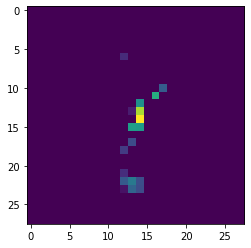

Loss:  tensor(32192348., device='cuda:0')
Epoch  1


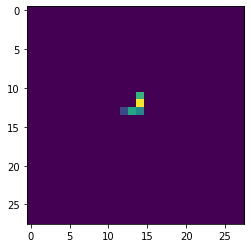

Loss:  tensor(32019292., device='cuda:0')
Epoch  2


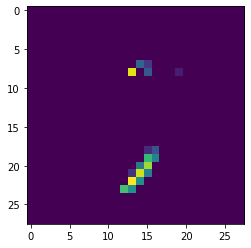

Loss:  tensor(31990074., device='cuda:0')
Epoch  3


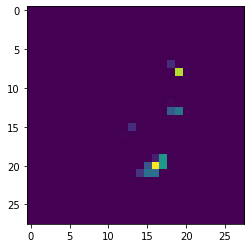

Loss:  tensor(31965772., device='cuda:0')
Epoch  4


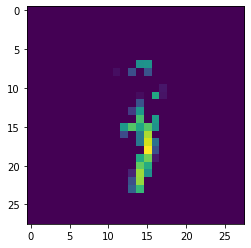

Loss:  tensor(31955234., device='cuda:0')
Epoch  5


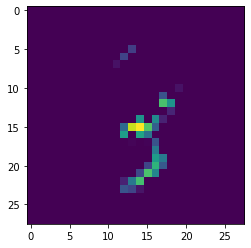

Loss:  tensor(31946520., device='cuda:0')
Epoch  6


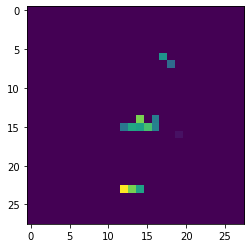

Loss:  tensor(31930742., device='cuda:0')
Epoch  7


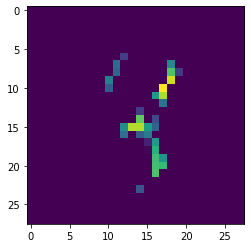

Loss:  tensor(31923096., device='cuda:0')
Epoch  8


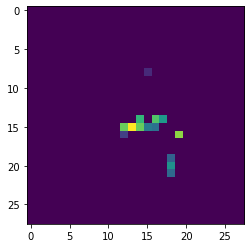

Loss:  tensor(31912786., device='cuda:0')
Epoch  9


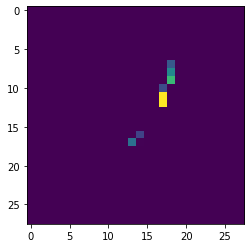

Loss:  tensor(31904364., device='cuda:0')
Epoch  10


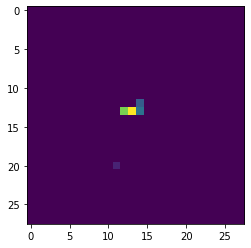

Loss:  tensor(31899552., device='cuda:0')
Epoch  11


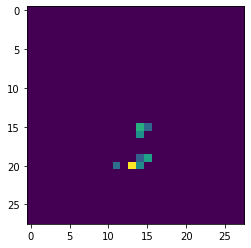

Loss:  tensor(31896424., device='cuda:0')
Epoch  12


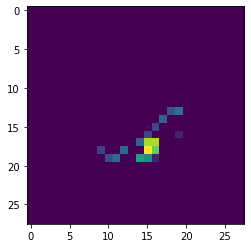

Loss:  tensor(31888712., device='cuda:0')
Epoch  13


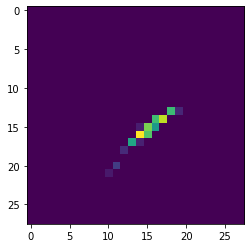

Loss:  tensor(31886266., device='cuda:0')
Epoch  14


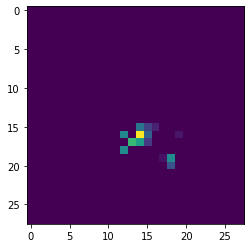

Loss:  tensor(31884020., device='cuda:0')
Epoch  15


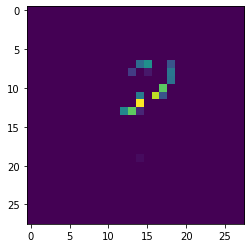

Loss:  tensor(31879776., device='cuda:0')
Epoch  16


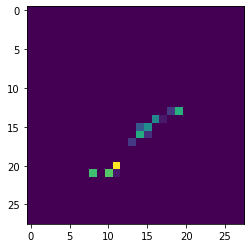

Loss:  tensor(31877544., device='cuda:0')
Epoch  17


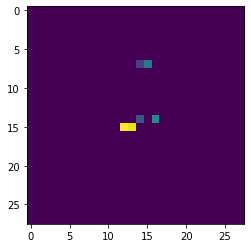

Loss:  tensor(31875982., device='cuda:0')
Epoch  18


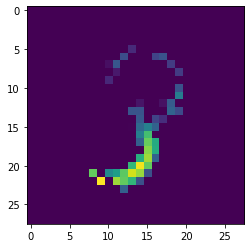

Loss:  tensor(31874556., device='cuda:0')
Epoch  19


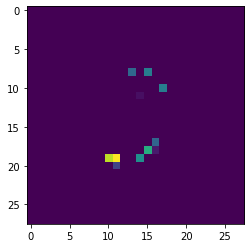

Loss:  tensor(31873246., device='cuda:0')
Epoch  20


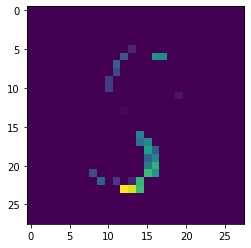

Loss:  tensor(31871958., device='cuda:0')
Epoch  21


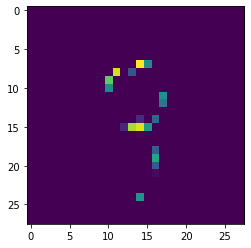

Loss:  tensor(31870736., device='cuda:0')
Epoch  22


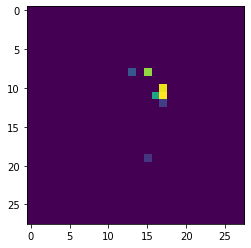

Loss:  tensor(31869878., device='cuda:0')
Epoch  23


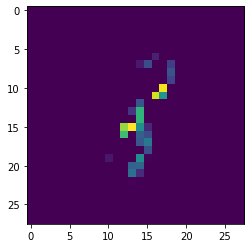

Loss:  tensor(31869068., device='cuda:0')
Epoch  24


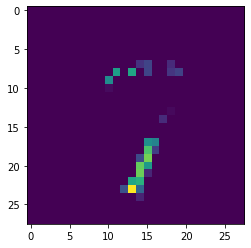

Loss:  tensor(31868100., device='cuda:0')
Epoch  25


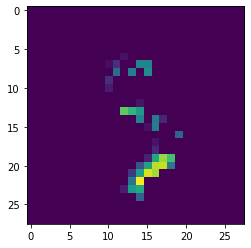

Loss:  tensor(31867168., device='cuda:0')
Epoch  26


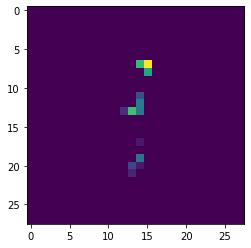

Loss:  tensor(31866586., device='cuda:0')
Epoch  27


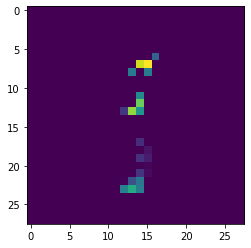

Loss:  tensor(31865564., device='cuda:0')
Epoch  28


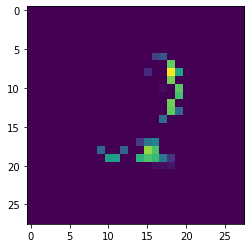

Loss:  tensor(31865134., device='cuda:0')
Epoch  29


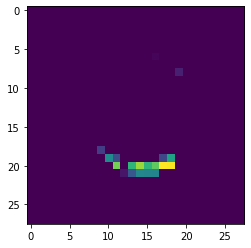

Loss:  tensor(31864320., device='cuda:0')
Epoch  30


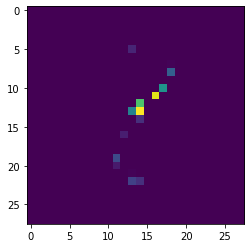

Loss:  tensor(31864000., device='cuda:0')
Epoch  31


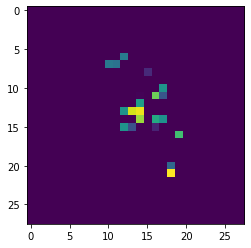

Loss:  tensor(31863420., device='cuda:0')
Epoch  32


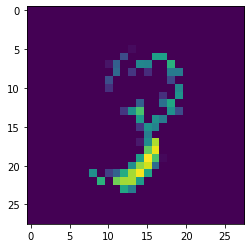

Loss:  tensor(31862774., device='cuda:0')
Epoch  33


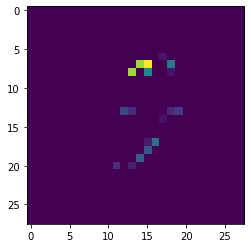

Loss:  tensor(31862110., device='cuda:0')
Epoch  34


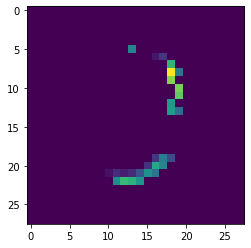

Loss:  tensor(31859822., device='cuda:0')
Epoch  35


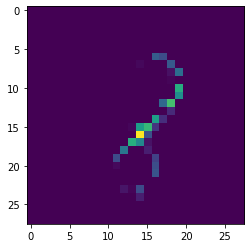

Loss:  tensor(31855420., device='cuda:0')
Epoch  36


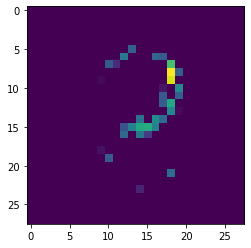

Loss:  tensor(31852396., device='cuda:0')
Epoch  37


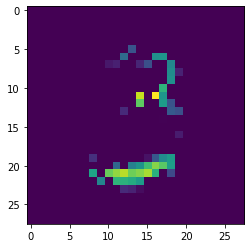

Loss:  tensor(31851420., device='cuda:0')
Epoch  38


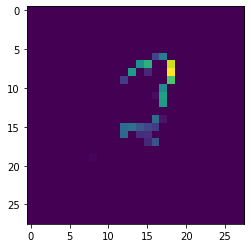

Loss:  tensor(31850696., device='cuda:0')
Epoch  39


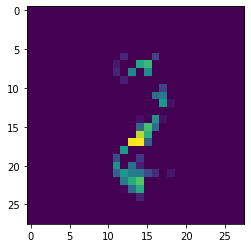

Loss:  tensor(31850328., device='cuda:0')
Epoch  40


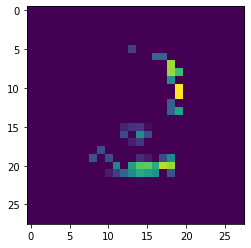

Loss:  tensor(31849826., device='cuda:0')
Epoch  41


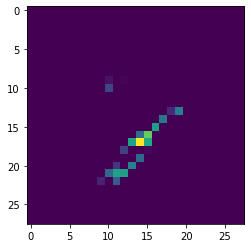

Loss:  tensor(31849542., device='cuda:0')
Epoch  42


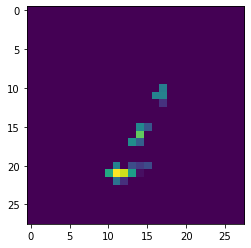

Loss:  tensor(31848702., device='cuda:0')
Epoch  43


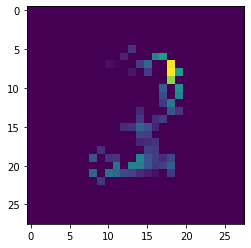

Loss:  tensor(31848340., device='cuda:0')
Epoch  44


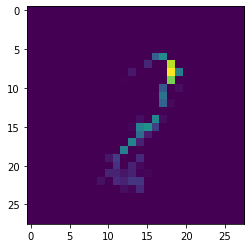

Loss:  tensor(31847802., device='cuda:0')
Epoch  45


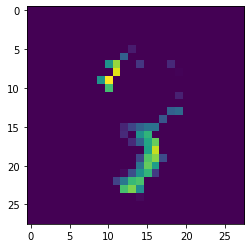

Loss:  tensor(31847354., device='cuda:0')
Epoch  46


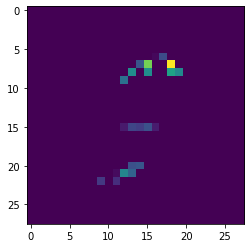

Loss:  tensor(31847142., device='cuda:0')
Epoch  47


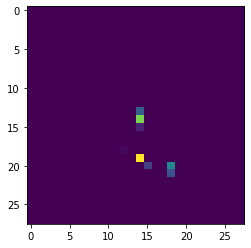

Loss:  tensor(31846530., device='cuda:0')
Epoch  48


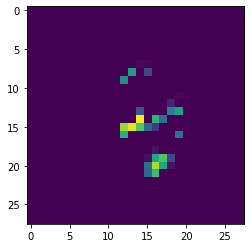

Loss:  tensor(31846216., device='cuda:0')
Epoch  49


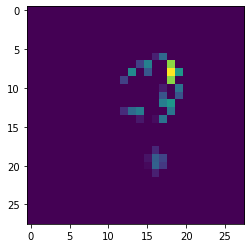

Loss:  tensor(31845828., device='cuda:0')
Epoch  50


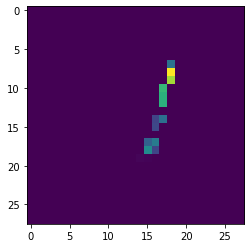

Loss:  tensor(31845522., device='cuda:0')
Epoch  51


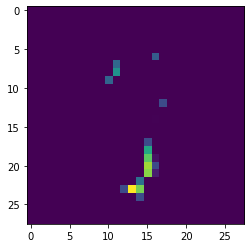

Loss:  tensor(31845090., device='cuda:0')
Epoch  52


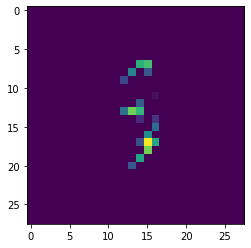

Loss:  tensor(31844838., device='cuda:0')
Epoch  53


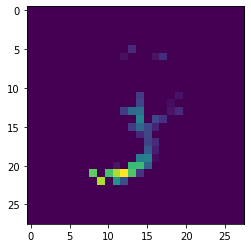

Loss:  tensor(31844582., device='cuda:0')
Epoch  54


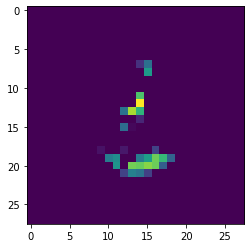

Loss:  tensor(31844390., device='cuda:0')
Epoch  55


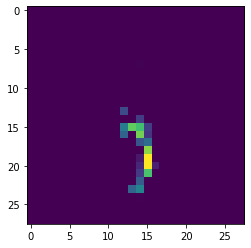

Loss:  tensor(31843688., device='cuda:0')
Epoch  56


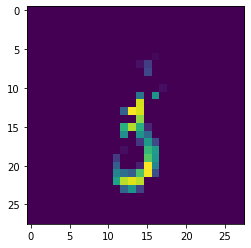

Loss:  tensor(31843390., device='cuda:0')
Epoch  57


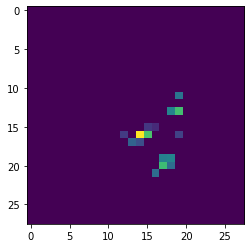

Loss:  tensor(31843110., device='cuda:0')
Epoch  58


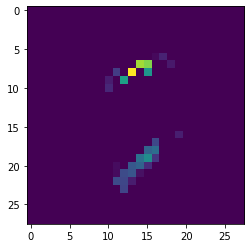

Loss:  tensor(31842974., device='cuda:0')
Epoch  59


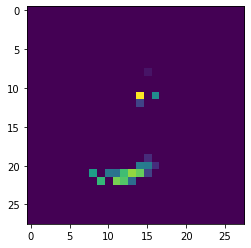

Loss:  tensor(31842686., device='cuda:0')
Epoch  60


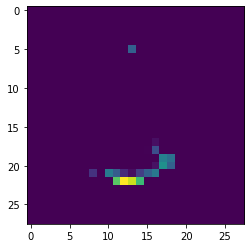

Loss:  tensor(31842364., device='cuda:0')
Epoch  61


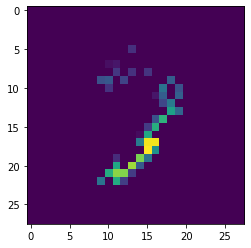

Loss:  tensor(31841914., device='cuda:0')
Epoch  62


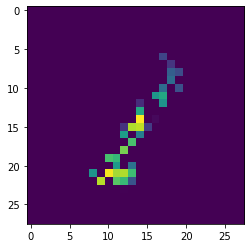

Loss:  tensor(31841706., device='cuda:0')
Epoch  63


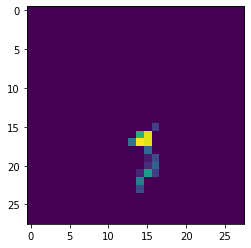

Loss:  tensor(31841190., device='cuda:0')
Epoch  64


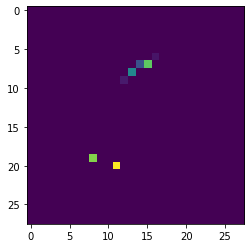

Loss:  tensor(31841180., device='cuda:0')
Epoch  65


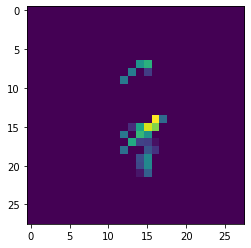

Loss:  tensor(31841046., device='cuda:0')
Epoch  66


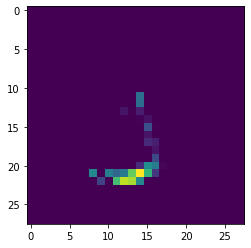

Loss:  tensor(31839632., device='cuda:0')
Epoch  67


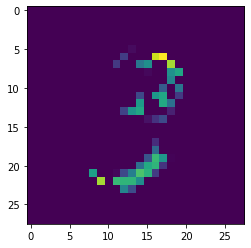

Loss:  tensor(31828692., device='cuda:0')
Epoch  68


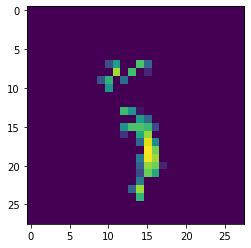

Loss:  tensor(31828234., device='cuda:0')
Epoch  69


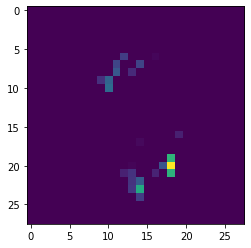

Loss:  tensor(31827622., device='cuda:0')
Epoch  70


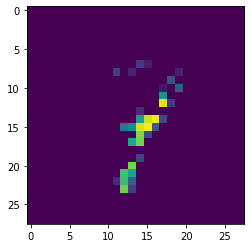

Loss:  tensor(31827182., device='cuda:0')
Epoch  71


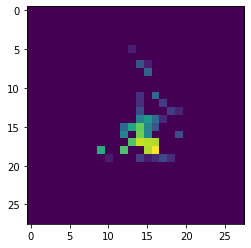

Loss:  tensor(31827102., device='cuda:0')
Epoch  72


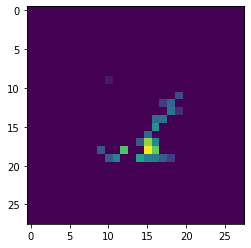

Loss:  tensor(31826604., device='cuda:0')
Epoch  73


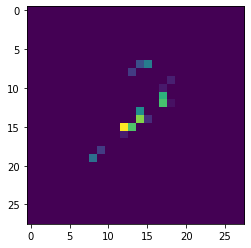

Loss:  tensor(31826414., device='cuda:0')
Epoch  74


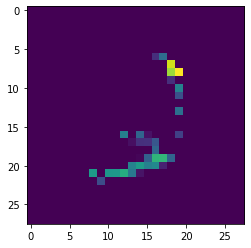

Loss:  tensor(31826194., device='cuda:0')
Epoch  75


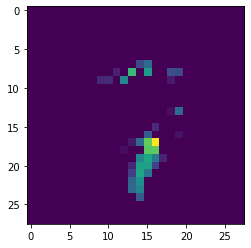

Loss:  tensor(31825954., device='cuda:0')
Epoch  76


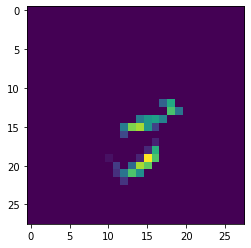

Loss:  tensor(31825708., device='cuda:0')
Epoch  77


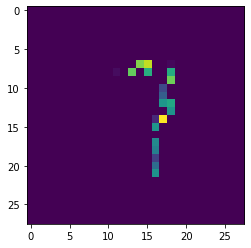

Loss:  tensor(31825500., device='cuda:0')
Epoch  78


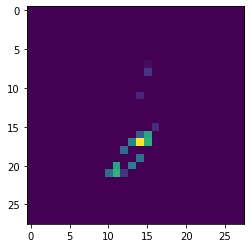

Loss:  tensor(31825450., device='cuda:0')
Epoch  79


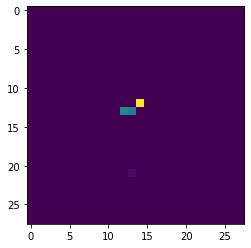

Loss:  tensor(31824864., device='cuda:0')
Epoch  80


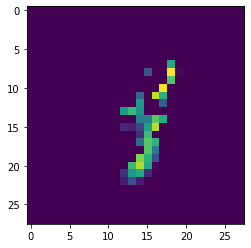

Loss:  tensor(31824980., device='cuda:0')
Epoch  81


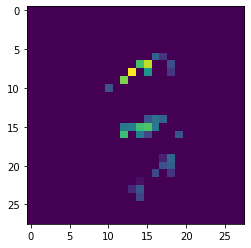

Loss:  tensor(31824564., device='cuda:0')
Epoch  82


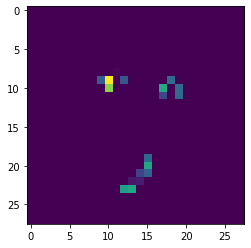

Loss:  tensor(31824598., device='cuda:0')
Epoch  83


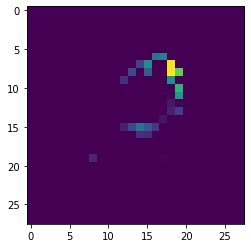

Loss:  tensor(31824222., device='cuda:0')
Epoch  84


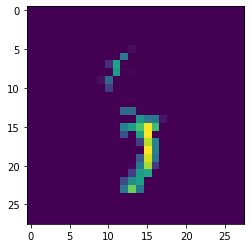

Loss:  tensor(31823918., device='cuda:0')
Epoch  85


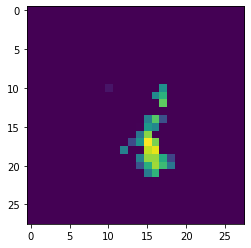

Loss:  tensor(31823932., device='cuda:0')
Epoch  86


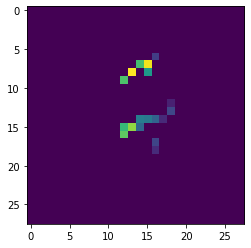

Loss:  tensor(31823638., device='cuda:0')
Epoch  87


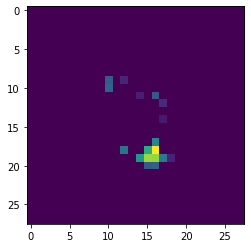

Loss:  tensor(31823758., device='cuda:0')
Epoch  88


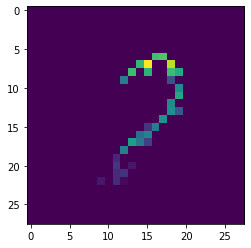

Loss:  tensor(31823378., device='cuda:0')
Epoch  89


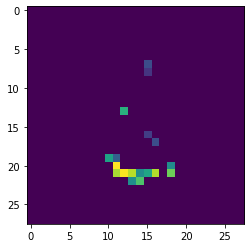

Loss:  tensor(31823306., device='cuda:0')
Epoch  90


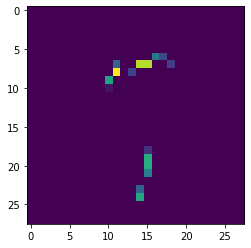

Loss:  tensor(31823234., device='cuda:0')
Epoch  91


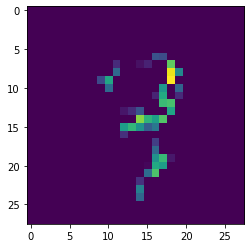

Loss:  tensor(31822974., device='cuda:0')
Epoch  92


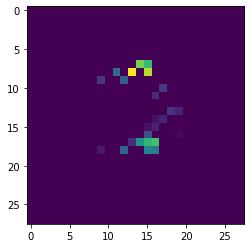

Loss:  tensor(31822748., device='cuda:0')
Epoch  93


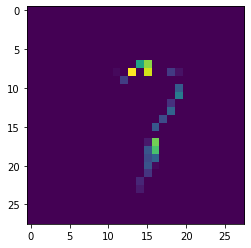

Loss:  tensor(31822874., device='cuda:0')
Epoch  94


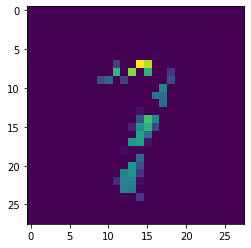

Loss:  tensor(31822456., device='cuda:0')
Epoch  95


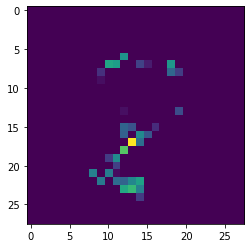

Loss:  tensor(31821946., device='cuda:0')
Epoch  96


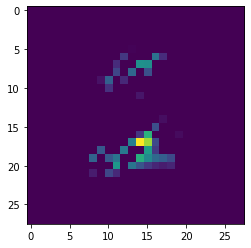

Loss:  tensor(31821052., device='cuda:0')
Epoch  97


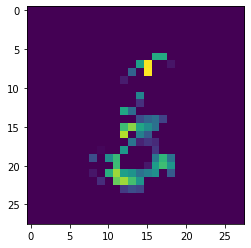

Loss:  tensor(31820224., device='cuda:0')
Epoch  98


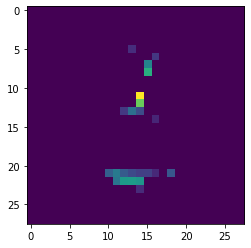

Loss:  tensor(31820416., device='cuda:0')
Epoch  99


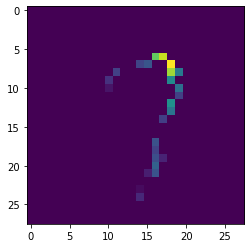

Loss:  tensor(31820246., device='cuda:0')


In [37]:
losses, vae_mlp_trained = train(vae_mlp, mnist_trainloader, epochs=100, crit=torch.nn.BCELoss(reduction='sum'), debug_with_images=True)

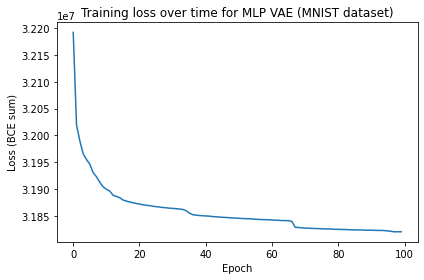

In [41]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE sum)')
plt.title('Training loss over time for MLP VAE (MNIST dataset)')
plt.tight_layout()

In [43]:
#torch.save(vae_mlp, '/content/drive/MyDrive/vae_mlp_trained_weights.pth')

In [46]:
#with open('/content/drive/MyDrive/vae_mlp_loss.pickle', 'wb') as mlp_outfile:
#  pickle.dump(losses, mlp_outfile)

## Sampling from the MLP VAE ##

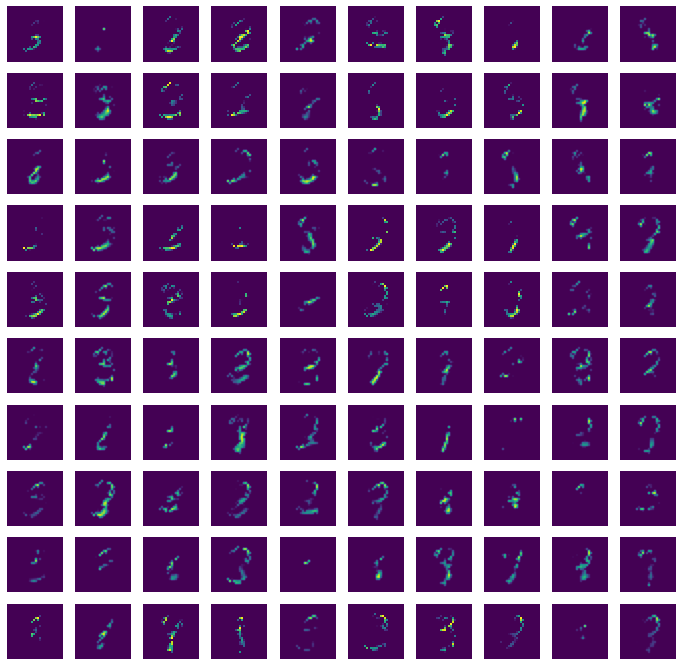

In [49]:

xs, ys = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
coords = np.dstack([xs, ys]).reshape(-1, 2)

reconstructs = []
for (x, y) in coords:
  reconstructs.append(vae_mlp.decoder.double().to(device)(torch.concat([torch.tensor([x,y]), torch.randn(6)]).to(device).double()))

fig, ax = plt.subplots(len(xs), len(ys), figsize=(12, 12))

for i in range(len(ax.flat)):
  ax.flat[i].imshow(reconstructs[i].cpu().reshape(28,28).detach())
  ax.flat[i].set_axis_off()

## Interpolating between two points in the latent space ##


In [104]:
p1_mlp = torch.randn(8).to(device)
p2_mlp = torch.randn(8).to(device)

In [103]:
def interpolate(src, dest, steps=9):
  '''Linearly interpolate between two vectors.'''
  
  step = (dest - src)/steps
  return [src + step * i for i in range(steps+1)]

In [69]:
def sample_latent(vae, start, stop, points=10):
  samples = interpolate(start, stop, points-1)
  outputs = [vae.to(device).decoder.double()(latent_sample.double().to(device)) for latent_sample in samples]
  return outputs

In [105]:
interpolated_samples_mlp = sample_latent(vae_mlp, p1_mlp, p2_mlp)

In [124]:
def plot_interpolated(interpolated):
  fig, axes = plt.subplots(ncols = len(interpolated), figsize=(len(interpolated)*2, 2))

  for i, ax in enumerate(axes):
    ax.imshow(interpolated[i].cpu().detach())
    ax.set_axis_off()
    ax.set_title(i)
  return fig, axes

In [106]:
interpolated_reshaped = [s.reshape(28, 28) for s in interpolated_samples_mlp]

Sampling latent space between tensor([ 0.9657, -0.2026,  0.8568,  0.0602,  0.5459,  0.4221, -0.8677,  0.6161],
       device='cuda:0') and tensor([ 0.2763, -1.4373,  0.3107, -1.2742, -1.5799, -0.2693, -0.0511,  0.0442],
       device='cuda:0')


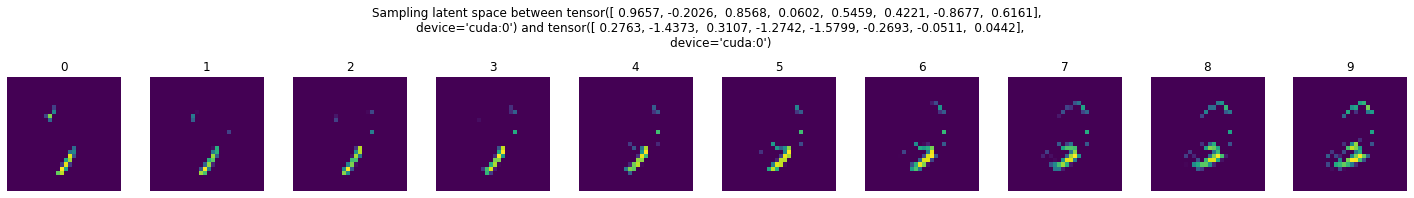

In [140]:
print('Sampling latent space between {start} and {stop}'.format(start=p1_mlp.detach(), stop=p2_mlp.detach()))
fig, axes = plot_interpolated(interpolated_reshaped)

fig.suptitle('Sampling latent space between {start} and {stop}'.format(start=p1_mlp.detach(), stop=p2_mlp.detach()), y=1.35)
fig.tight_layout()

# CNN VAE for SVHN data #

In [86]:
class CNNEncoder(torch.nn.Module):
  def __init__(self, image_size=32, channels=3, hidden=256, latent=32):
    super(CNNEncoder, self).__init__()

    self.conv1 = torch.nn.Conv2d(channels, 32, 3, 2)
    self.leaky_relu1 = torch.nn.LeakyReLU(0.2)
    self.conv2 = torch.nn.Conv2d(32, 64, 3, 2)
    self.leaky_relu2 = torch.nn.LeakyReLU(0.2)
    self.conv3 = torch.nn.Conv2d(64, 128, 3, 2)
    self.leaky_relu3 = torch.nn.LeakyReLU(0.2)
    self.conv4 = torch.nn.Conv2d(128, 256, 3, 2)
    self.leaky_relu4 = torch.nn.LeakyReLU(0.2)
    self.flatten = torch.nn.Flatten()

    self.mus = torch.nn.Linear(hidden, latent)
    self.log_sigma_sq = torch.nn.Linear(hidden, latent)
  
  def forward(self, batch):
    out = self.conv1(batch)
    out = self.leaky_relu1(out)
    out = self.conv2(out)
    out = self.leaky_relu2(out)
    out = self.conv3(out)
    out = self.leaky_relu3(out)
    out = self.conv4(out)
    out = self.leaky_relu4(out)
    out = self.flatten(out)
    return self.mus(out), self.log_sigma_sq(out)

In [87]:
class CNNDecoder(torch.nn.Module):
  def __init__(self, channels, hidden, latent):
    super(CNNDecoder, self).__init__()

    self.linear = torch.nn.Linear(latent, hidden)
    self.unflatten = torch.nn.Unflatten(1, (hidden, 1, 1))
    self.ctransp1 = torch.nn.ConvTranspose2d(hidden, 128, 4, 2)
    self.relu1 = torch.nn.ReLU()
    self.ctransp2 = torch.nn.ConvTranspose2d(128, 64, 5, 2)
    self.relu2 = torch.nn.ReLU()
    self.ctransp3 = torch.nn.ConvTranspose2d(64, 32, 6, 2)
    self.relu3 = torch.nn.ReLU()
    self.ctransp4 = torch.nn.ConvTranspose2d(32, channels, 7, 1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, batch):
    out = self.linear(batch)
    out = self.unflatten(out)
    out = self.ctransp1(out)
    out = self.relu1(out)
    out = self.ctransp2(out)
    out = self.relu2(out)
    out = self.ctransp3(out)
    out = self.relu3(out)
    out = self.ctransp4(out)
    return self.sigmoid(out)

In [88]:
class VAECNN(torch.nn.Module):
  def __init__(self, image_size, channels=3, hidden=256, latent=32):
    super(VAECNN, self).__init__()
    self.encoder = CNNEncoder(image_size, channels, hidden, latent)
    self.decoder = CNNDecoder(channels, hidden, latent)

  def reparam(self, mus, log_sigmas_sq):
    epsilons = torch.randn_like(log_sigmas_sq)
    z = mus + epsilons * (log_sigmas_sq * 0.5).exp() #get std out of log variance
    #0.5 * log(x) = log(sqrt(x))

    return z
  
  def forward(self, batch):
    mus, log_sigmas_sq = self.encoder(batch)
    self.mus = mus
    self.sigmas = log_sigmas_sq
    z = self.reparam(mus, log_sigmas_sq)
    return self.decoder(z)

In [146]:
vae_cnn = VAECNN(32)

Using device  cuda
Epoch  0


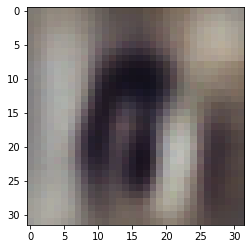

Loss:  tensor(1.3965e+08, device='cuda:0')
Epoch  1


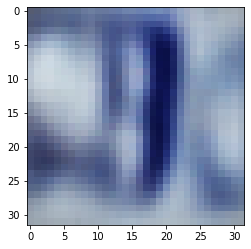

Loss:  tensor(1.3737e+08, device='cuda:0')
Epoch  2


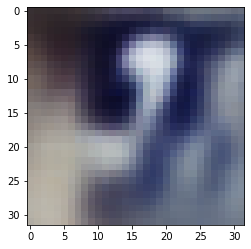

Loss:  tensor(1.3711e+08, device='cuda:0')
Epoch  3


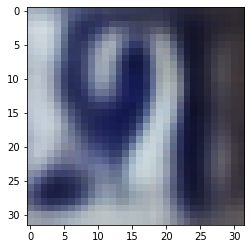

Loss:  tensor(1.3704e+08, device='cuda:0')
Epoch  4


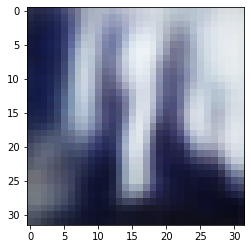

Loss:  tensor(1.3699e+08, device='cuda:0')
Epoch  5


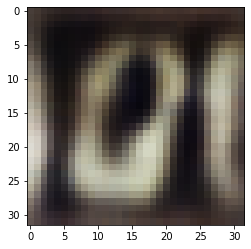

Loss:  tensor(1.3695e+08, device='cuda:0')
Epoch  6


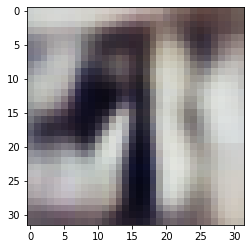

Loss:  tensor(1.3692e+08, device='cuda:0')
Epoch  7


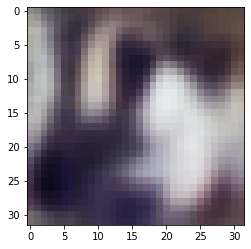

Loss:  tensor(1.3690e+08, device='cuda:0')
Epoch  8


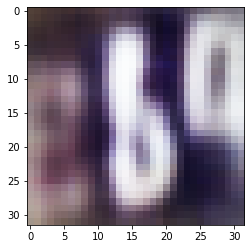

Loss:  tensor(1.3687e+08, device='cuda:0')
Epoch  9


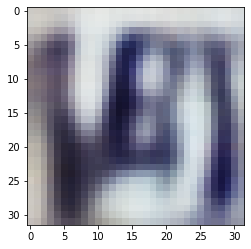

Loss:  tensor(1.3685e+08, device='cuda:0')
Epoch  10


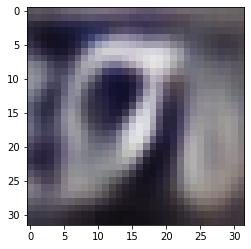

Loss:  tensor(1.3684e+08, device='cuda:0')
Epoch  11


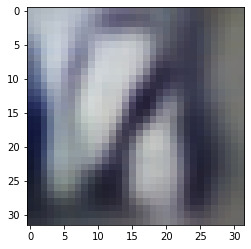

Loss:  tensor(1.3682e+08, device='cuda:0')
Epoch  12


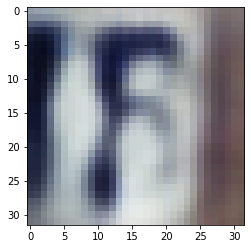

Loss:  tensor(1.3681e+08, device='cuda:0')
Epoch  13


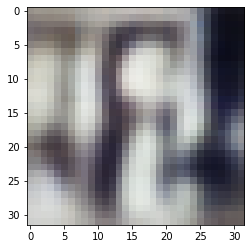

Loss:  tensor(1.3680e+08, device='cuda:0')
Epoch  14


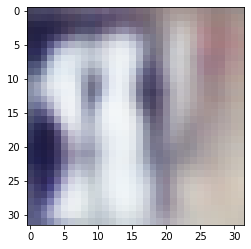

Loss:  tensor(1.3679e+08, device='cuda:0')
Epoch  15


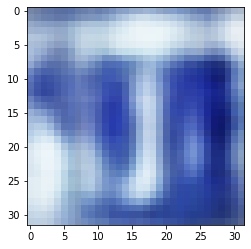

Loss:  tensor(1.3678e+08, device='cuda:0')
Epoch  16


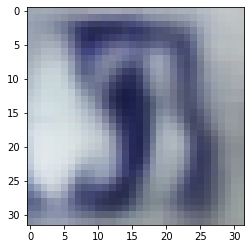

Loss:  tensor(1.3677e+08, device='cuda:0')
Epoch  17


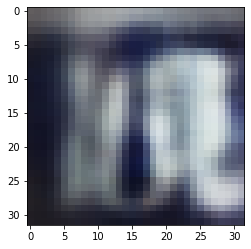

Loss:  tensor(1.3676e+08, device='cuda:0')
Epoch  18


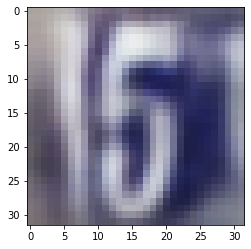

Loss:  tensor(1.3676e+08, device='cuda:0')
Epoch  19


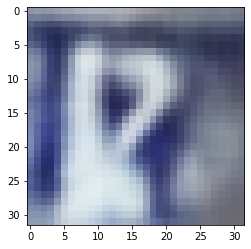

Loss:  tensor(1.3675e+08, device='cuda:0')
Epoch  20


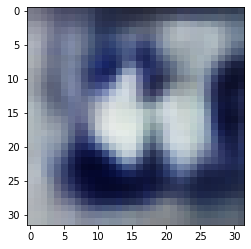

Loss:  tensor(1.3674e+08, device='cuda:0')
Epoch  21


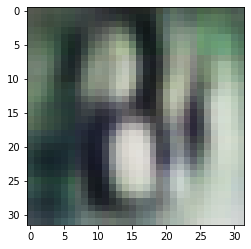

Loss:  tensor(1.3673e+08, device='cuda:0')
Epoch  22


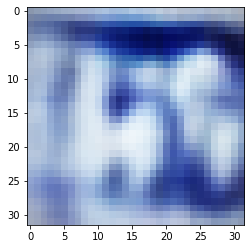

Loss:  tensor(1.3673e+08, device='cuda:0')
Epoch  23


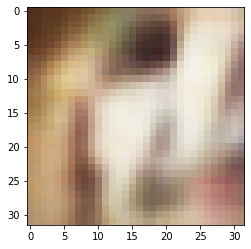

Loss:  tensor(1.3672e+08, device='cuda:0')
Epoch  24


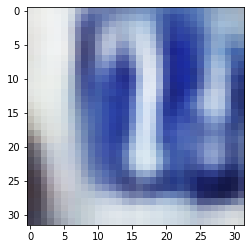

Loss:  tensor(1.3672e+08, device='cuda:0')
Epoch  25


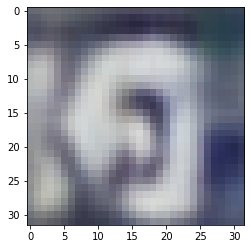

Loss:  tensor(1.3671e+08, device='cuda:0')
Epoch  26


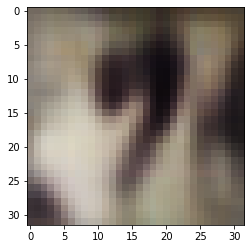

Loss:  tensor(1.3671e+08, device='cuda:0')
Epoch  27


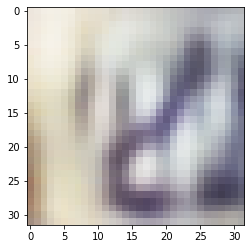

Loss:  tensor(1.3670e+08, device='cuda:0')
Epoch  28


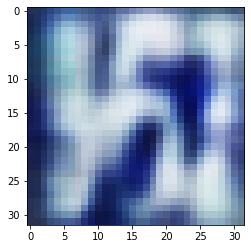

Loss:  tensor(1.3670e+08, device='cuda:0')
Epoch  29


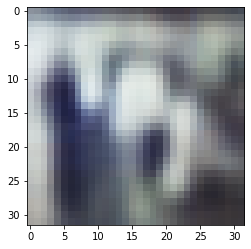

Loss:  tensor(1.3670e+08, device='cuda:0')
Epoch  30


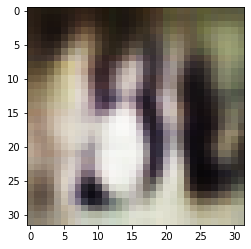

Loss:  tensor(1.3669e+08, device='cuda:0')
Epoch  31


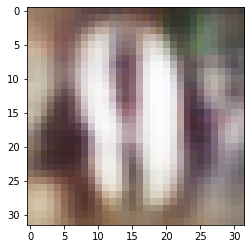

Loss:  tensor(1.3669e+08, device='cuda:0')
Epoch  32


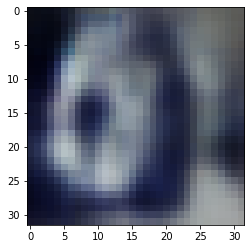

Loss:  tensor(1.3668e+08, device='cuda:0')
Epoch  33


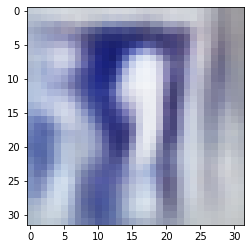

Loss:  tensor(1.3668e+08, device='cuda:0')
Epoch  34


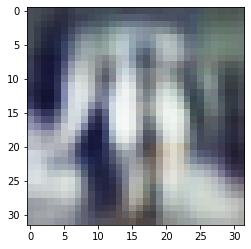

Loss:  tensor(1.3668e+08, device='cuda:0')
Epoch  35


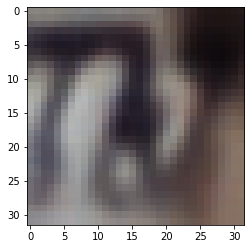

Loss:  tensor(1.3668e+08, device='cuda:0')
Epoch  36


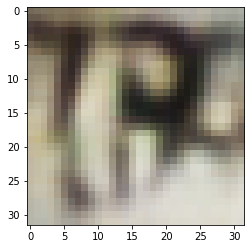

Loss:  tensor(1.3667e+08, device='cuda:0')
Epoch  37


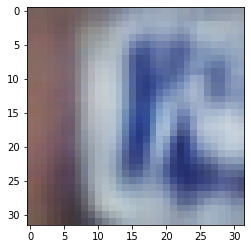

Loss:  tensor(1.3667e+08, device='cuda:0')
Epoch  38


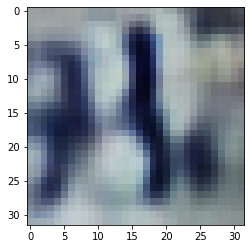

Loss:  tensor(1.3667e+08, device='cuda:0')
Epoch  39


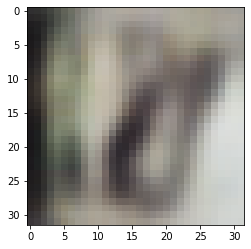

Loss:  tensor(1.3667e+08, device='cuda:0')
Epoch  40


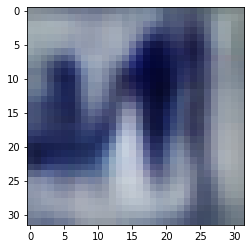

Loss:  tensor(1.3666e+08, device='cuda:0')
Epoch  41


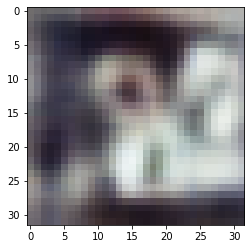

Loss:  tensor(1.3666e+08, device='cuda:0')
Epoch  42


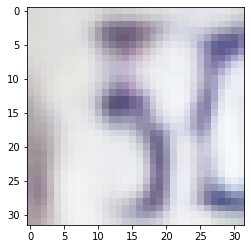

Loss:  tensor(1.3666e+08, device='cuda:0')
Epoch  43


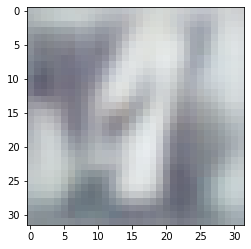

Loss:  tensor(1.3666e+08, device='cuda:0')
Epoch  44


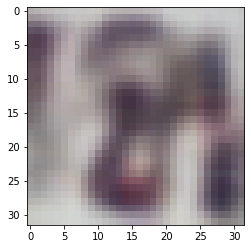

Loss:  tensor(1.3666e+08, device='cuda:0')
Epoch  45


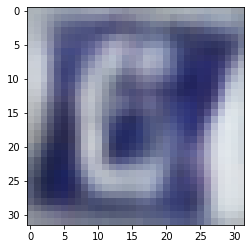

Loss:  tensor(1.3665e+08, device='cuda:0')
Epoch  46


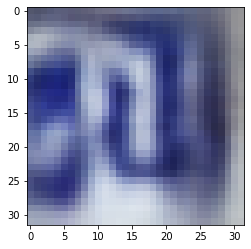

Loss:  tensor(1.3665e+08, device='cuda:0')
Epoch  47


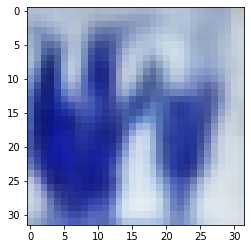

Loss:  tensor(1.3665e+08, device='cuda:0')
Epoch  48


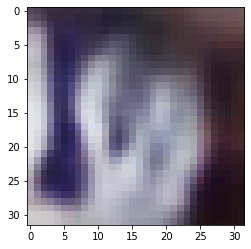

Loss:  tensor(1.3665e+08, device='cuda:0')
Epoch  49


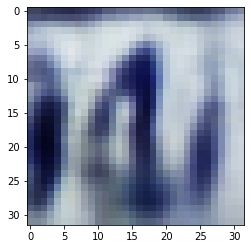

Loss:  tensor(1.3664e+08, device='cuda:0')
Epoch  50


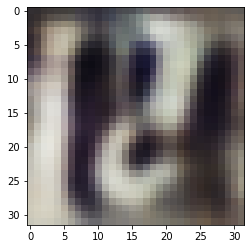

Loss:  tensor(1.3664e+08, device='cuda:0')
Epoch  51


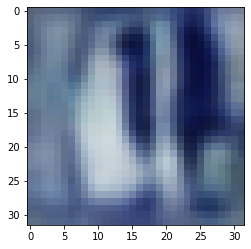

Loss:  tensor(1.3664e+08, device='cuda:0')
Epoch  52


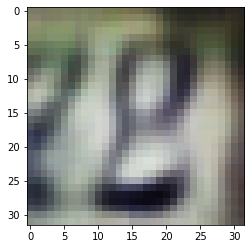

Loss:  tensor(1.3664e+08, device='cuda:0')
Epoch  53


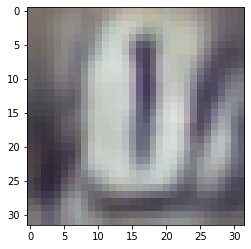

Loss:  tensor(1.3664e+08, device='cuda:0')
Epoch  54


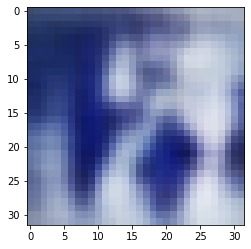

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  55


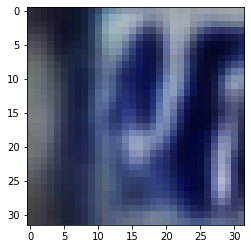

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  56


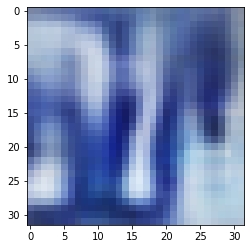

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  57


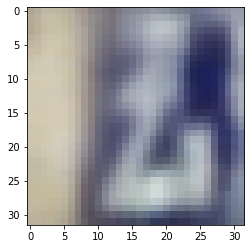

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  58


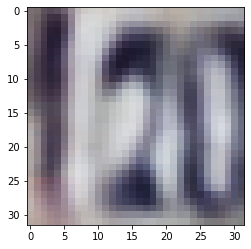

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  59


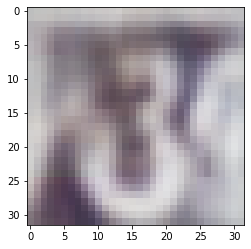

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  60


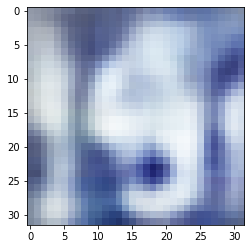

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  61


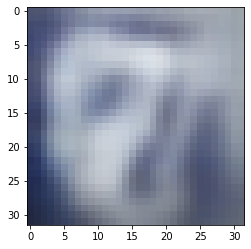

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  62


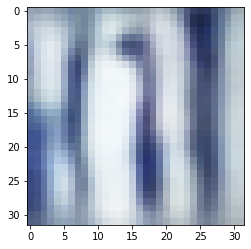

Loss:  tensor(1.3663e+08, device='cuda:0')
Epoch  63


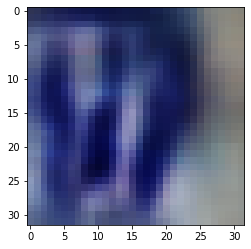

Loss:  tensor(1.3662e+08, device='cuda:0')
Epoch  64


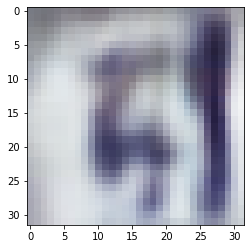

Loss:  tensor(1.3662e+08, device='cuda:0')
Epoch  65


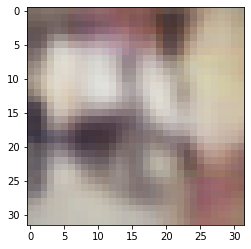

Loss:  tensor(1.3662e+08, device='cuda:0')
Epoch  66


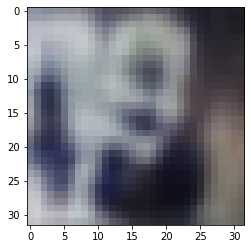

Loss:  tensor(1.3662e+08, device='cuda:0')
Epoch  67


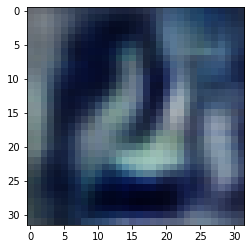

Loss:  tensor(1.3662e+08, device='cuda:0')
Epoch  68


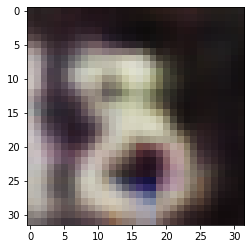

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  69


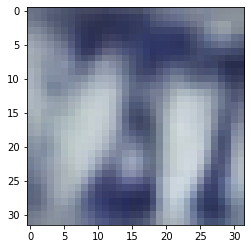

Loss:  tensor(1.3662e+08, device='cuda:0')
Epoch  70


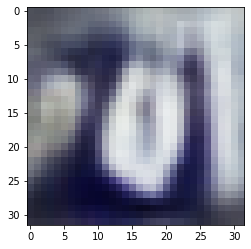

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  71


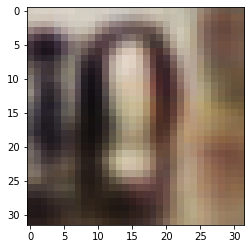

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  72


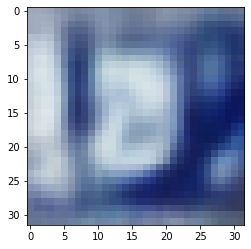

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  73


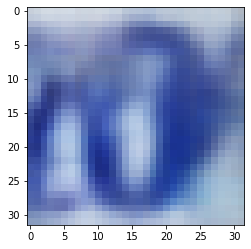

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  74


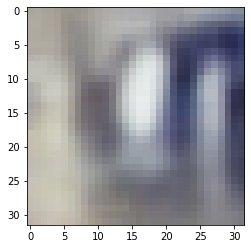

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  75


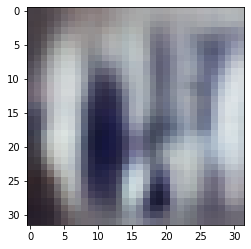

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  76


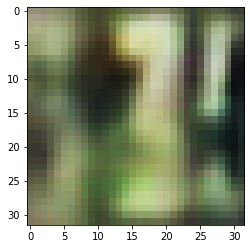

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  77


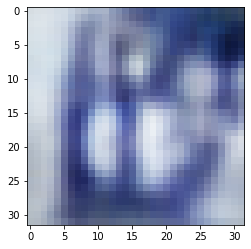

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  78


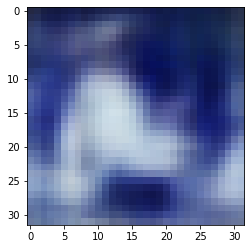

Loss:  tensor(1.3661e+08, device='cuda:0')
Epoch  79


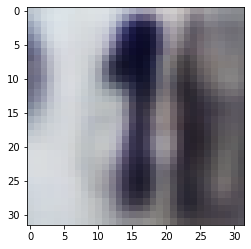

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  80


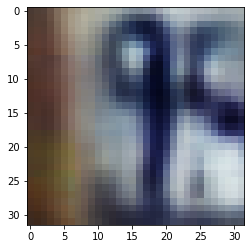

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  81


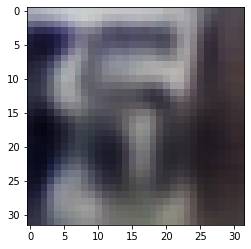

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  82


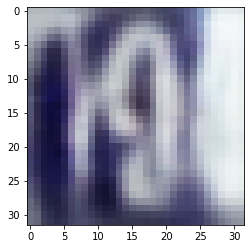

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  83


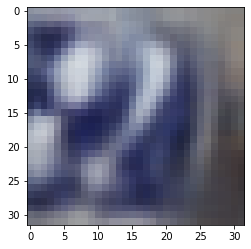

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  84


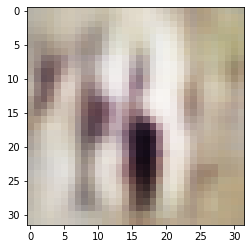

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  85


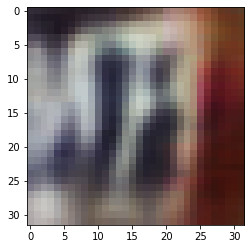

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  86


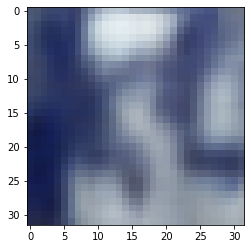

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  87


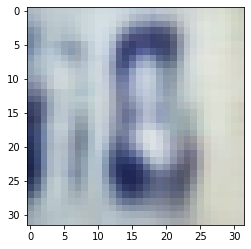

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  88


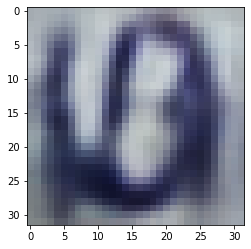

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  89


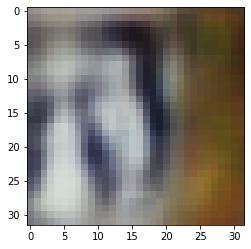

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  90


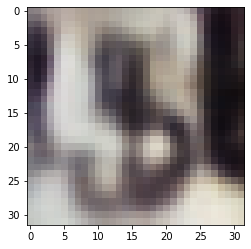

Loss:  tensor(1.3660e+08, device='cuda:0')
Epoch  91


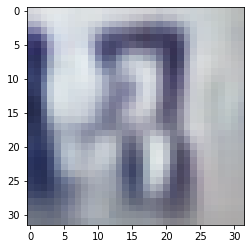

Loss:  tensor(1.3659e+08, device='cuda:0')
Epoch  92


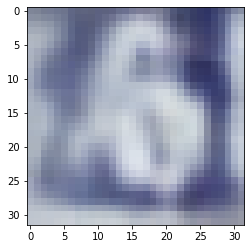

Loss:  tensor(1.3659e+08, device='cuda:0')
Epoch  93


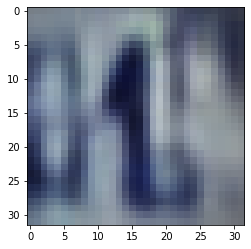

Loss:  tensor(1.3659e+08, device='cuda:0')
Epoch  94


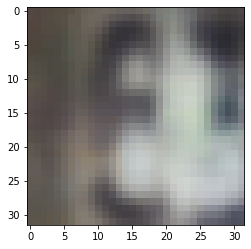

Loss:  tensor(1.3659e+08, device='cuda:0')
Epoch  95


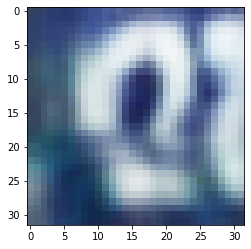

Loss:  tensor(1.3659e+08, device='cuda:0')
Epoch  96


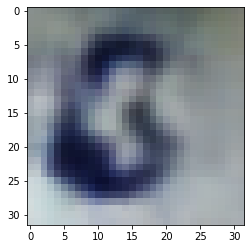

Loss:  tensor(1.3659e+08, device='cuda:0')
Epoch  97


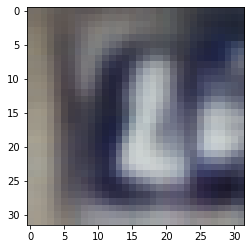

Loss:  tensor(1.3659e+08, device='cuda:0')
Epoch  98


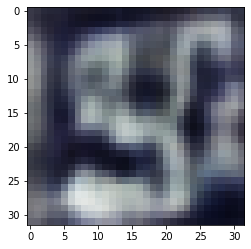

Loss:  tensor(1.3659e+08, device='cuda:0')
Epoch  99


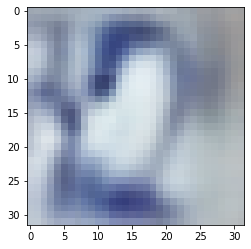

Loss:  tensor(1.3659e+08, device='cuda:0')


In [147]:
cnn_losses, vae_cnn_trained = train(vae_cnn, svhn_trainloader, 100, debug_with_images=True, crit=torch.nn.BCELoss(reduction='sum'))

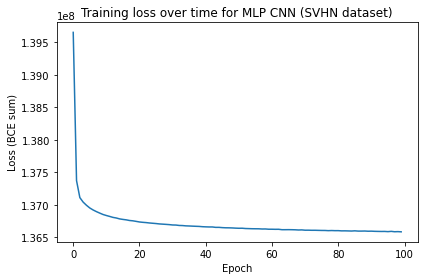

In [151]:
plt.plot(cnn_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE sum)')
plt.title('Training loss over time for MLP CNN (SVHN dataset)')
plt.tight_layout()

In [148]:
#torch.save(vae_cnn, '/content/drive/MyDrive/vae_cnn_trained_weights.pth')

In [149]:
#with open('/content/drive/MyDrive/vae_cnn_train_losses.pickle', 'wb') as cnn_outfile:
#  pickle.dump(cnn_losses, cnn_outfile)

## Sampling the CNN VAE ##

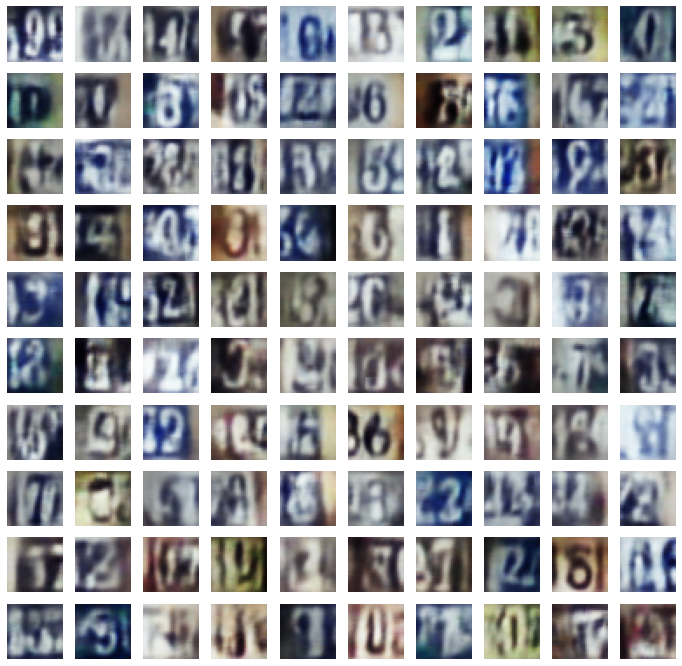

In [162]:
xs, ys = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
coords = np.dstack([xs, ys]).reshape(-1, 2)

reconstructs = []
for (x, y) in coords:
  reconstructs.append(vae_cnn.decoder.double().to(device)(torch.concat([torch.tensor([x,y]), torch.randn(30)]).unsqueeze(0).to(device).double()))

fig, ax = plt.subplots(len(xs), len(ys), figsize=(12, 12))

for i in range(len(ax.flat)):
  ax.flat[i].imshow(reconstructs[i].cpu().squeeze().permute(1,2,0).detach())
  ax.flat[i].set_axis_off()

## Interpolating between two points in the latent space (CNN) ##

In [182]:
p1_cnn = torch.randn((1, 32)).to(device)
p2_cnn = torch.randn((1, 32)).to(device)

In [183]:
interpolated_samples_cnn = sample_latent(vae_cnn, p1_cnn, p2_cnn)

In [184]:
interpolated_reshaped_cnn = [s.squeeze().permute(1,2,0) for s in interpolated_samples_cnn]

Sampling latent space between tensor([[-0.6179, -1.3694, -2.8645, -0.3699,  0.7077, -0.0403,  1.5037, -0.0589,
         -0.0526, -0.9477, -0.4973,  1.7072, -0.7293,  0.3192, -1.1254,  0.1105,
         -0.2804,  0.4675,  2.4197, -0.1948, -0.2040,  1.5845,  0.9633,  0.0507,
          0.8671,  0.1676, -1.3687,  1.1607, -1.3966, -0.1046, -1.0284,  0.5474]],
       device='cuda:0') and tensor([[-1.5587, -0.0862, -1.2962, -0.2694,  0.1101,  0.5460,  0.0290, -1.7565,
         -0.7844, -0.0374, -0.5564, -2.4579, -1.4007,  2.1726,  0.2142,  1.3693,
          0.0124,  1.1717, -0.2989, -0.7386,  1.0578,  0.0644, -1.0562,  1.6527,
         -0.2938, -0.1339, -1.3498,  0.2854, -0.4110,  0.3823,  0.4194, -1.1922]],
       device='cuda:0')


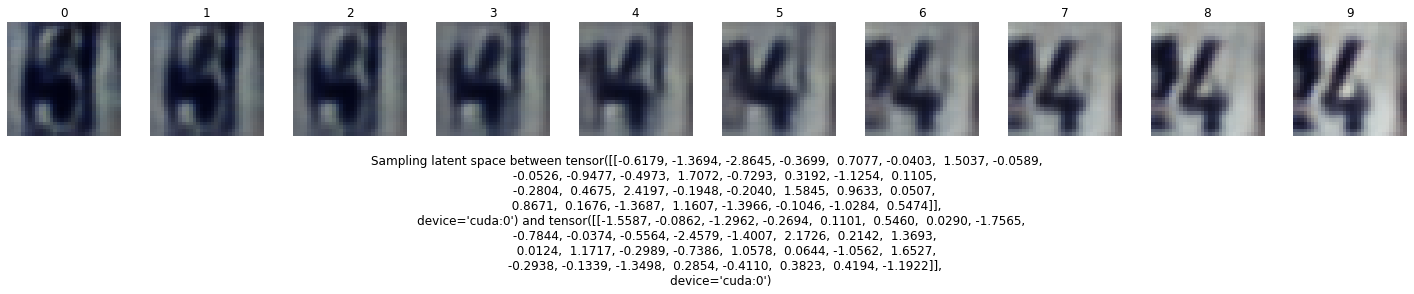

In [186]:
print('Sampling latent space between {start} and {stop}'.format(start=p1_cnn.detach(), stop=p2_cnn.detach()))
fig, axes = plot_interpolated(interpolated_reshaped_cnn)

fig.suptitle('Sampling latent space between {start} and {stop}'.format(start=p1_cnn.detach(), stop=p2_cnn.detach()), y=-0.05)
fig.tight_layout()

# FID scoring with Inception V3 #

In [66]:
import scipy.linalg

In [79]:
inception = torchvision.models.inception_v3(pretrained=True)

In [68]:
class FeatureExtractor():
  def __init__(self):
    self.features = None

  def __call__(self, module, inputs, outputs):
    self.features = outputs.reshape(-1, 2048)

  def clear(self):
    self.features = None

In [80]:
inception = inception.to(device)
inception.eval();
fe = FeatureExtractor()
#register hook at very last layer before final output
inception.dropout.register_forward_hook(fe)

In [6]:
upsample = torch.nn.Upsample((299, 299))

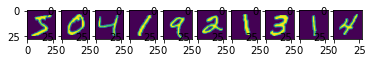

In [8]:
f, axx = plt.subplots(ncols=10)
i = 0
for dig in mnist_data_train.data[:10]:
  axx[i].imshow(dig)
  i += 1

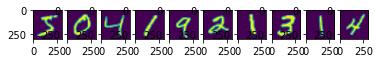

In [11]:
f, axx = plt.subplots(ncols=10)
i = 0
mnist_10 = mnist_data_train.data[:10]
for dig in upsample(mnist_10.unsqueeze(1)):
  axx[i].imshow(dig.squeeze())
  i += 1

upsampled shape:  torch.Size([16, 1, 299, 299])
repeated shape:  torch.Size([16, 3, 299, 299])


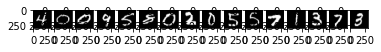

In [17]:
i = 0
for data, labels in mnist_trainloader:
  upsampled = upsample(data)
  repeated = upsampled.repeat(1, 3, 1, 1)
  print('upsampled shape: ', upsampled.shape)
  print('repeated shape: ', repeated.shape)
  f, axx = plt.subplots(ncols=16)
  j = 0
  for dig in repeated:
    axx[j].imshow(dig.squeeze().permute(1,2,0))
    j += 1
  i += 1
  if i > 0:
    break

In [65]:

def fid_score(features1, features2):
  mean1 = features1.mean(axis=0)
  mean2 = features2.mean(axis=0)

  cov1 = np.cov(features1, rowvar=False)
  cov2 = np.cov(features2, rowvar=False)

  sum_mean_diff_sq = torch.sum((mean1 - mean2)**2) #sum of squared differences between means
  sqrt_cov_product = scipy.linalg.sqrtm(cov1.dot(cov2)).real #real part of matrix square root of covariance matrix products

  return sum_mean_diff_sq + np.trace(cov1 + cov2 - 2 * sqrt_cov_product)


In [81]:
#compare n samples from real data with n generated samples
sample_size = 32
i = 0
n = 10
fids = []
inception = inception.double()
with torch.no_grad():
  for data, labels in mnist_trainloader:
    upsampled = upsample(data)
    repeated = upsampled.repeat(1, 3, 1, 1)
    inception(repeated.to(device).double());
    real_features = fe.features
    fe.clear()

    fakes = vae_mlp.decoder.double()(torch.randn(sample_size, 8).double()).reshape(sample_size, 1, 28, 28)
    upsampled_fakes = upsample(fakes)
    repeated_fakes = upsampled_fakes.repeat(1, 3, 1, 1)
    inception(repeated_fakes.to(device).double());
    fake_features = fe.features

    fids.append(fid_score(real_features, fake_features))
    i += 1
    if i >= n:
      break

In [82]:
fids

[tensor(239.5455, dtype=torch.float64),
 tensor(243.4857, dtype=torch.float64),
 tensor(237.3480, dtype=torch.float64),
 tensor(250.7680, dtype=torch.float64),
 tensor(229.3390, dtype=torch.float64),
 tensor(252.1556, dtype=torch.float64),
 tensor(254.7873, dtype=torch.float64),
 tensor(271.0105, dtype=torch.float64),
 tensor(232.5123, dtype=torch.float64),
 tensor(253.9231, dtype=torch.float64)]

In [85]:
print(torch.mean(torch.tensor(fids)))

tensor(246.4875, dtype=torch.float64)

In [93]:
#compare n samples from real data with n generated samples for the CNN
sample_size = 32
i = 0
n = 10
fids_svhn = []
fe.clear()
inception = inception.double()
vae_cnn_double = vae_cnn.double()
with torch.no_grad():
  for data, labels in svhn_trainloader:
    upsampled = upsample(data)
    repeated = upsampled.repeat(1, 3, 1, 1)
    inception(repeated.to(device).double());
    real_features = fe.features
    fe.clear()

    fakes = vae_cnn_double.decoder(torch.randn(sample_size, 32).double())
    upsampled_fakes = upsample(fakes)
    repeated_fakes = upsampled_fakes.repeat(1, 3, 1, 1)
    inception(repeated_fakes.to(device).double());
    fake_features = fe.features

    fids_svhn.append(fid_score(real_features, fake_features))
    print(i)
    i += 1
    if i >= n:
      break

0
1
2
3
4
5
6
7
8
9


In [95]:
fids_svhn

[tensor(100.1519, dtype=torch.float64),
 tensor(95.1954, dtype=torch.float64),
 tensor(95.8316, dtype=torch.float64),
 tensor(87.2443, dtype=torch.float64),
 tensor(83.2330, dtype=torch.float64),
 tensor(81.7602, dtype=torch.float64),
 tensor(96.8825, dtype=torch.float64),
 tensor(96.1505, dtype=torch.float64),
 tensor(85.9249, dtype=torch.float64),
 tensor(90.3068, dtype=torch.float64)]

In [97]:
print(torch.mean(torch.tensor(fids_svhn)))

tensor(91.2681, dtype=torch.float64)
